<a href="https://colab.research.google.com/github/Sravanthiporeddy5/MLT/blob/main/Virtual_Dressing_Room.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install scikit-learn pandas numpy

In [19]:
%matplotlib inline

In [20]:
!pip install scikit-learn joblib numpy matplotlib pillow --quiet

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import joblib

In [22]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [23]:
def generate_synthetic_data(n=3500, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    rows = []
    for _ in range(n):
        gender = np.random.choice(['M','F'])
        age = int(np.random.normal(30, 8))
        height_cm = int(np.random.normal(170, 9))
        chest = int(np.random.normal(95, 10))
        waist = int(np.random.normal(78, 8))
        hip = int(np.random.normal(98, 9))
        shoulder = round(np.random.normal(41, 4), 1)
        fabric_stretch = round(np.random.uniform(0.6, 1.2), 2)
        garment_type = np.random.choice(['Tshirt','Shirt','Dress','Jacket','Jeans'])

        size_score = (height_cm*0.2 + chest*0.6 + hip*0.2) / 3
        if size_score < 85:
            size = 'XS'
        elif size_score < 95:
            size = 'S'
        elif size_score < 105:
            size = 'M'
        elif size_score < 115:
            size = 'L'
        else:
            size = 'XL'

        intended_size = np.random.choice(['S','M','L','XL'], p=[0.25,0.4,0.25,0.1])
        size_map = {'XS':0,'S':1,'M':2,'L':3,'XL':4}
        size_diff = size_map[intended_size] - size_map.get(size,2)

        if abs(size_diff) == 0:
            fit = 'Good'
        elif size_diff < 0:
            fit = 'Good' if fabric_stretch > 1.05 else 'Tight'
        else:
            fit = 'Loose' if fabric_stretch < 0.95 else 'Good'

        rows.append({
            'gender': gender,
            'age': age,
            'height_cm': height_cm,
            'chest_cm': chest,
            'waist_cm': waist,
            'hip_cm': hip,
            'shoulder_cm': shoulder,
            'fabric_stretch': fabric_stretch,
            'garment_type': garment_type,
            'true_size': size,
            'intended_size': intended_size,
            'fit': fit
        })

    return pd.DataFrame(rows)

df = generate_synthetic_data()
df.head()


,gender,age,height_cm,chest_cm,waist_cm,hip_cm,shoulder_cm,fabric_stretch,garment_type,true_size,intended_size,fit
0,M,25,174,99,88,89,40.5,0.88,Jeans,XS,M,Loose
1,F,26,171,97,78,111,47.2,0.60,Tshirt,XS,M,Loose
2,M,25,168,97,71,99,40.9,0.88,Jeans,XS,M,Loose
3,M,27,169,95,83,96,40.9,0.74,Jacket,XS,M,Loose
4,M,39,173,91,68,103,38.2,0.86,Shirt,XS,M,Loose


In [24]:
feature_cols = [
    'gender','age','height_cm','chest_cm','waist_cm','hip_cm',
    'shoulder_cm','fabric_stretch','garment_type'
]

X = df[feature_cols]
y_size = df['true_size']
y_fit = df['fit']

numeric_features = ['age','height_cm','chest_cm','waist_cm','hip_cm','shoulder_cm','fabric_stretch']
categorical_features = ['gender','garment_type']

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [25]:
X_train, X_test, y_size_train, y_size_test, y_fit_train, y_fit_test = train_test_split(
    X, y_size, y_fit, test_size=0.2, random_state=RANDOM_STATE, stratify=y_size
)


In [26]:
knn_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3,5,7],
    'knn__weights': ['uniform','distance']
}

knn_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy')
knn_search.fit(X_train, y_size_train)

knn_best = knn_search.best_estimator_

print("Best KNN Params:", knn_search.best_params_)


Best KNN Params: {'knn__n_neighbors': 3, 'knn__weights': 'uniform'}


KNN Classification Report:
              precision    recall  f1-score   support

          XS       1.00      1.00      1.00       700

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


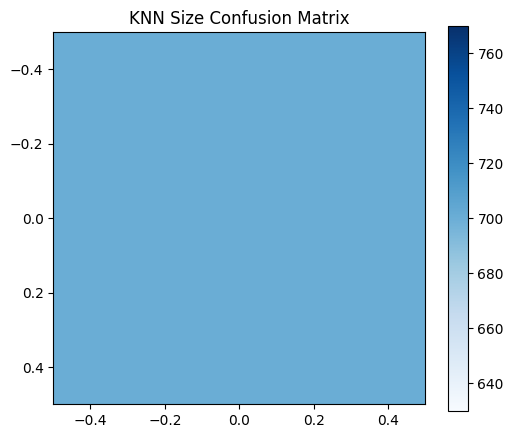

In [37]:
y_pred_size = knn_best.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_size_test, y_pred_size))

cm = confusion_matrix(y_size_test, y_pred_size)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("KNN Size Confusion Matrix")
plt.colorbar()
plt.show()



In [28]:
dt_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_param_grid = {
    'dt__max_depth': [4,6,10,None],
    'dt__min_samples_leaf': [1,2,5]
}

dt_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='accuracy')
dt_search.fit(X_train, y_fit_train)

dt_best = dt_search.best_estimator_

print("Best Decision Tree Params:", dt_search.best_params_)


Best Decision Tree Params: {'dt__max_depth': 4, 'dt__min_samples_leaf': 1}


Decision Tree Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       287
       Loose       1.00      1.00      1.00       413

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



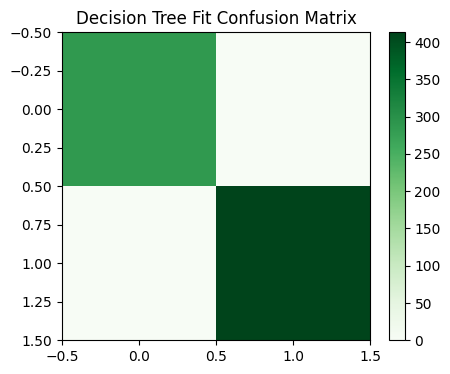

In [29]:
y_pred_fit = dt_best.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_fit_test, y_pred_fit))

cm2 = confusion_matrix(y_fit_test, y_pred_fit)

plt.figure(figsize=(5,4))
plt.imshow(cm2, cmap='Greens')
plt.title("Decision Tree Fit Confusion Matrix")
plt.colorbar()
plt.show()


In [30]:
os.makedirs("models", exist_ok=True)

joblib.dump(knn_best, "models/knn_size_model.joblib")
joblib.dump(dt_best, "models/dt_fit_model.joblib")

print("Models saved successfully!")


Models saved successfully!


In [31]:
def predict_virtual_dressing_room(user_input):
    sample = pd.DataFrame([user_input])
    size = knn_best.predict(sample)[0]
    fit = dt_best.predict(sample)[0]
    return size, fit

example_user = {
    'gender': 'F',
    'age': 25,
    'height_cm': 164,
    'chest_cm': 88,
    'waist_cm': 70,
    'hip_cm': 94,
    'shoulder_cm': 38.5,
    'fabric_stretch': 0.9,
    'garment_type': 'Tshirt'
}

predict_virtual_dressing_room(example_user)


('XS', 'Loose')